#Tugas Individu: Implementasi Arsitektur Transformer dari Nol dengan NumPy


*   Rani Nirmala Prakoso
*   22/493982/TK/54153
* [Link GitHub](https://github.com/ranisedangbekerja/Transformer-Decoder-Only-GPT-style-From-Scratch-NumPy.git)
* [Link Laporan](https://docs.google.com/document/d/143Yp9bOPVNyE9Gfw42_arzxL19WM01B1AUsxfHUoxGk/edit?usp=sharing)

#Library NumPy
Hanya mengunakan NumPy untuk operasi matematis (matriks, vektor, fungsi aktivasi).2 Tidak diperbolehkan memakai library deep learning atau modul siap pakai(torch, tensorflow, transformers, dsb.)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(42)
print('NumPy:', np.__version__)

NumPy: 2.0.2


In [15]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=-1, keepdims=True)

def layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)

def make_causal_mask(seq_len, batch=1, heads=1):
    base = np.tril(np.ones((seq_len, seq_len), dtype=np.float32))
    return base.reshape(1,1,seq_len,seq_len)

# Komponen 1 Token Embedding

* Matriks embedding dan urutan token:
$$
\mathbf{E} \in \mathbb{R}^{|V| \times d}, \quad
\mathbf{x} \in \text{NS}, \quad
\mathbf{X} = \mathbf{E}[\mathbf{x}] \in \mathbb{R}^{S \times d}
$$

* Mengubah indeks token (angka hasil tokenisasi) menjadi vektor berdimensi
d_model.

* Matriks embedding berukuran (vocab_size, d_model).

* Inisialisasi dibagi sqrt(d_model) agar stabil.

In [16]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.weights = np.random.randn(vocab_size, d_model).astype(np.float32) / np.sqrt(d_model)

    def __call__(self, x):
        return self.weights[x]

#Komponen 2 Positional Encoding (Sinusoidal)

* Rumus
$$
\mathrm{PE}(p,2i)=\sin\Big(\frac{p}{10000^{\frac{2i}{d}}}\Big), \qquad
\mathrm{PE}(p,2i+1)=\cos!\Big(\frac{p}{10000^{\frac{2i}{d}}}\Big).
$$
Gabungkan:
$$
Z^{(0)} = X + \mathrm{PE}.
$$
* Menambahkan informasi posisi ke embedding (karena Transformer tidak punya urutan bawaan).

* Nilai sinus dan cosinus dengan frekuensi berbeda, sehingga tiap posisi unik.

* Output berukuran (seq_len, d_model).

In [17]:
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    pos_encoding = np.zeros((seq_len, d_model), dtype=np.float32)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return pos_encoding

# Komponen 3 Scaled Dot-Product Attention
* Rumus
$$
\mathrm{softmax}(z)_i ;=; \frac{e^{z_i}}{\sum_j e^{z_j}}.
$$
Stabilisasi numerik.Gunakan (\tilde z = z - \max(z)) sebelum eksponensial:
$$
\mathrm{softmax}(z)_i ;=; \frac{e^{,z_i-\max(z)}}{\sum_j e^{,z_j-\max(z)}}.
$$
* Q, K, V: query, key, value.
* Hitung kesamaan query-key, skala dengan sqrt(d_k), lalu softmax → bobot perhatian.
* Causal mask: menutup posisi masa depan.
* Output: kombinasi nilai (V) berbobot.

In [18]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0,1,3,2)) / math.sqrt(d_k)
    if mask is not None:
        scores = np.where(mask==0, -1e9, scores)
    attn_weights = softmax(scores)
    output = np.matmul(attn_weights, V)
    return output, attn_weights

# Komponen 4 Multi-Head Attention
* Rumus
$$
S ;=; \frac{QK^\top}{\sqrt{d_k}} + M,
\qquad
A ;=; \mathrm{softmax}(S),
\qquad
\mathrm{Attn}(Q,K,V) ;=; A,V.
$$
* Membagi d_model menjadi beberapa head → belajar pola berbeda secara paralel.
* Setelah dihitung, hasil tiap head digabung lalu diproyeksikan dengan Wo.

In [19]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.Wq = np.random.randn(d_model, d_model).astype(np.float32) / np.sqrt(d_model)
        self.Wk = np.random.randn(d_model, d_model).astype(np.float32) / np.sqrt(d_model)
        self.Wv = np.random.randn(d_model, d_model).astype(np.float32) / np.sqrt(d_model)
        self.Wo = np.random.randn(d_model, d_model).astype(np.float32) / np.sqrt(d_model)

    def split_heads(self, x, batch_size):
        return x.reshape(batch_size, -1, self.num_heads, self.d_head).transpose(0,2,1,3)

    def combine_heads(self, x):
        b,h,seq,d = x.shape
        return x.transpose(0,2,1,3).reshape(b, seq, h*d)

    def __call__(self, x, mask=None):
        batch_size = x.shape[0]
        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv
        Qh = self.split_heads(Q, batch_size)
        Kh = self.split_heads(K, batch_size)
        Vh = self.split_heads(V, batch_size)
        attn_out, attn_weights = scaled_dot_product_attention(Qh, Kh, Vh, mask)
        combined = self.combine_heads(attn_out)
        out = combined @ self.Wo
        diagnostics = {'Q': Qh, 'K': Kh, 'V': Vh, 'attn_weights': attn_weights}
        return out, attn_weights, diagnostics


# Komponen 5 Feed Forward Network (FFN)
* Rumus
$$
\mathrm{FFN}(z) ;=; W_2,\sigma!\big(W_1 z + b_1\big) + b_2.
$$
* Dua layer linear: d_model → d_ff → d_model.

* Aktivasi ReLU di tengah.

* Memberikan non-linearitas agar model bisa menangkap representasi kompleks.

In [20]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff).astype(np.float32) / np.sqrt(d_model)
        self.b1 = np.zeros((d_ff,), dtype=np.float32)
        self.W2 = np.random.randn(d_ff, d_model).astype(np.float32) / np.sqrt(d_ff)
        self.b2 = np.zeros((d_model,), dtype=np.float32)

    def __call__(self, x):
        return (np.maximum(0, x @ self.W1 + self.b1)) @ self.W2 + self.b2


# Komponen 6 Decoder Block
* Rumus
$$
\mu = \mathrm{mean}(x),\qquad
\sigma^2 = \mathrm{var}(x),\qquad
\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}},\qquad
\mathrm{LN}(x) = \gamma \odot \hat{x} + \beta.
$$
* Pre-norm: layer norm diterapkan sebelum residual.

* Pipeline:

1. Multi-head attention → residual → layer norm.

2. FFN → residual → layer norm.

In [21]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)

    def __call__(self, x, mask=None):
        attn_out, attn_weights, diag = self.mha(x, mask)
        x = layer_norm(x + attn_out)
        ffn_out = self.ffn(x)
        x = layer_norm(x + ffn_out)
        return x, attn_weights, diag


# Komponen 7 Transformer Decoder-Only
* Rumus
$$
Q_j = Z W^Q_j,\quad
K_j = Z W^K_j,\quad
V_j = Z W^V_j,\qquad (j=1,\dots,h)
$$
$$
H_j = \mathrm{Attn}(Q_j,K_j,V_j),\qquad
H = [H_1;\ldots;H_h] \in \mathbb{R}^{S\times d},\qquad
\mathrm{MHA}(Z) = H W^O.
$$
* Input: token ID.

* Output:

1. logits dengan ukuran (batch, seq_len, vocab_size).

2. probs distribusi softmax untuk prediksi token berikutnya.

3. attn_maps untuk visualisasi attention.

# Komponen 8 Causal Mask
* Rumus
$$
M_{t,s}=
\begin{cases}
0, & s \le t,\
-\infty, & s > t,
\end{cases}
\qquad\Rightarrow\qquad
A_{t,s}=0 \text{ untuk } s>t.
$$

```
mask = make_causal_mask(seq_len)
```


* Membuat matriks segitiga bawah (lower triangular).

* Posisi i hanya bisa melihat ≤ i.

* Memastikan autoregresif → cocok untuk GPT-style.

# Output Layer


```
logits = out @ Wo
probs = softmax(logits)
```


* Proyeksi hasil decoder ke ukuran vocab.

* Softmax → distribusi probabilitas token berikutnya.

**Alur.**
$$
X ;=; E[\text{tokens}] ;+; \mathrm{PE}[:S],\qquad
\text{ulang } L \text{ kali:}; X \leftarrow \mathrm{DecoderBlock}(X, M).
$$
**Proyeksi keluaran (weight tying).**
$$
\mathrm{logits} ;=; X,E^\top ;\in; \mathbb{R}^{S\times |V|}.
$$
**Distribusi token berikutnya (posisi terakhir).**
$$
p(\cdot \mid x_{\le S-1}) ;=; \mathrm{softmax}\big(\mathrm{logits}_{S-1,:}\big).
$$




In [22]:
class Transformer:
    def __init__(self, vocab_size, d_model=128, num_heads=8, d_ff=512, num_layers=4, max_len=64, weight_tying=False):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, d_model)
        self.layers = [DecoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.Wo = np.random.randn(d_model, vocab_size).astype(np.float32) / np.sqrt(d_model)
        self.weight_tying = weight_tying
        if weight_tying:
            self.Wo = None

    def __call__(self, x):
        batch, seq_len = x.shape
        mask = make_causal_mask(seq_len)
        out = self.embedding(x) + self.pos_encoding[:seq_len]
        attn_all = []
        diagnostics = []
        for layer in self.layers:
            out, attn_w, diag = layer(out, mask)
            attn_all.append(attn_w)
            diagnostics.append(diag)
        if self.weight_tying:
            logits = out @ self.embedding.weights.T
        else:
            logits = out @ self.Wo
        probs = softmax(logits)
        return logits, probs, attn_all, diagnostics

In [23]:
def attention_stats(attn):
    stats = []
    for layer_idx, layer_attn in enumerate(attn):
        mean_per_head = layer_attn.mean(axis=(0,2,3))
        std_per_head = layer_attn.std(axis=(0,2,3))
        min_per_head = layer_attn.min(axis=(0,2,3))
        max_per_head = layer_attn.max(axis=(0,2,3))
        stats.append({'layer': layer_idx,
                      'mean': mean_per_head,
                      'std': std_per_head,
                      'min': min_per_head,
                      'max': max_per_head})
    return stats

def plot_layer_heads(attn_layer, layer_idx, token_labels=None, vmax=None):
    batch, heads, seq, _ = attn_layer.shape
    example = 0
    cols = min(4, heads)
    rows = math.ceil(heads/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = np.array(axes).reshape(-1)
    for h in range(heads):
        ax = axes[h]
        im = ax.imshow(attn_layer[example, h], aspect='auto', vmin=0, vmax=vmax)
        ax.set_title(f'Layer {layer_idx} Head {h}')
        ax.set_xlabel('key pos')
        ax.set_ylabel('query pos')
    for i in range(heads, len(axes)):
        axes[i].axis('off')
    fig.colorbar(im, ax=axes[:heads].tolist(), shrink=0.6)
    plt.tight_layout()
    plt.show()


def plot_aggregate_stats(stats):
    layers = [s['layer'] for s in stats]
    means = [s['mean'].mean() for s in stats]
    stds = [s['std'].mean() for s in stats]
    plt.figure(figsize=(8,4))
    plt.plot(layers, means, marker='o', label='mean across heads')
    plt.plot(layers, stds, marker='o', label='std across heads')
    plt.xlabel('layer')
    plt.ylabel('value')
    plt.title('Aggregate attention statistics')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_histogram_all(attn, bins=30):
    all_vals = np.concatenate([a.flatten() for a in attn])
    plt.figure(figsize=(6,4))
    plt.hist(all_vals, bins=bins)
    plt.title('Histogram of attention values (all layers)')
    plt.xlabel('attention weight')
    plt.ylabel('count')
    plt.show()

In [24]:
def validate_masking(attn, seq_len):
    violations = []
    for layer_idx, layer_attn in enumerate(attn):
        avg = layer_attn.mean(axis=(0,1))
        for i in range(seq_len):
            future_mass = avg[i, i+1:].sum()
            if future_mass > 1e-6:
                violations.append((layer_idx, i, future_mass))
    return violations

In [25]:
vocab_size = 200
model = Transformer(vocab_size=vocab_size, d_model=128, num_heads=8, d_ff=512, num_layers=4, max_len=64, weight_tying=True)

batch = 2
seq_len = 20
sample_input = np.random.randint(0, vocab_size, (batch, seq_len))
logits, probs, attn_all, diagnostics = model(sample_input)

print('bentuk input:', sample_input)
print('logits shape:', logits.shape)
print('probs shape:', probs.shape)
print('attn layers:', len(attn_all))
print('attn layer shape example:', attn_all[0].shape)


bentuk input: [[ 82  54 170  80 191 138  19  71 153 152  72 125  93 171 148  95  93  83
  106 121]
 [  0 198  15 128  39 110 108  47 188 176  40 159   5  48 179  94 199 136
   30 178]]
logits shape: (2, 20, 200)
probs shape: (2, 20, 200)
attn layers: 4
attn layer shape example: (2, 8, 20, 20)


Layer 0: mean(heads)=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05], std(heads)=[0.08128466 0.08362509 0.08217339 0.08108697 0.08148555 0.08134986
 0.08108206 0.08109922]
Layer 1: mean(heads)=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05], std(heads)=[0.0842748  0.08402999 0.08435425 0.08686857 0.0886333  0.08828057
 0.08323666 0.08349068]
Layer 2: mean(heads)=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05], std(heads)=[0.08356231 0.08209371 0.0814357  0.08124138 0.08198916 0.0824213
 0.08156381 0.08326283]
Layer 3: mean(heads)=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05], std(heads)=[0.08267384 0.08136276 0.08166574 0.08287516 0.08202544 0.08157439
 0.08170598 0.08133902]


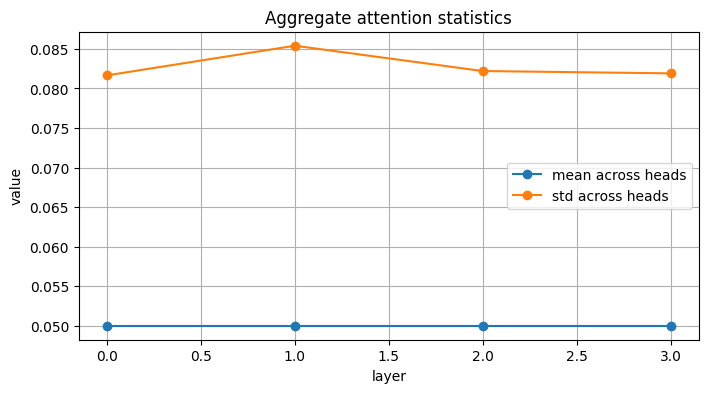

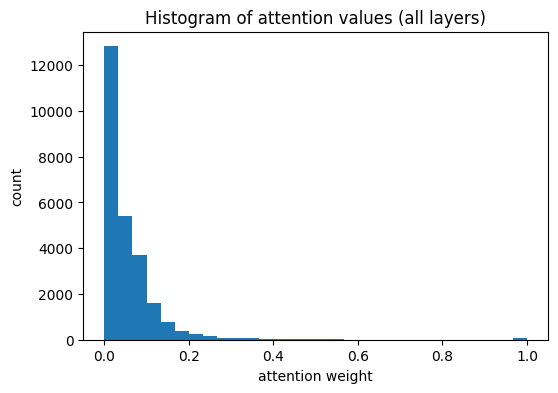

In [26]:
stats = attention_stats(attn_all)
for s in stats:
    print(f"Layer {s['layer']}: mean(heads)={s['mean']}, std(heads)={s['std']}")

plot_aggregate_stats(stats)
plot_histogram_all(attn_all)


# Analisis Heatmap
Visualisasi heatmap attention memperlihatkan distribusi fokus tiap head, dan histogram attention
menunjukkan sebaran nilai atensi yang mayoritas kecil (<0.2) namun terkonsentrasi di beberapa
posisi kunci.



=== Layer 0 per-head heatmaps ===


/tmp/ipython-input-246960940.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


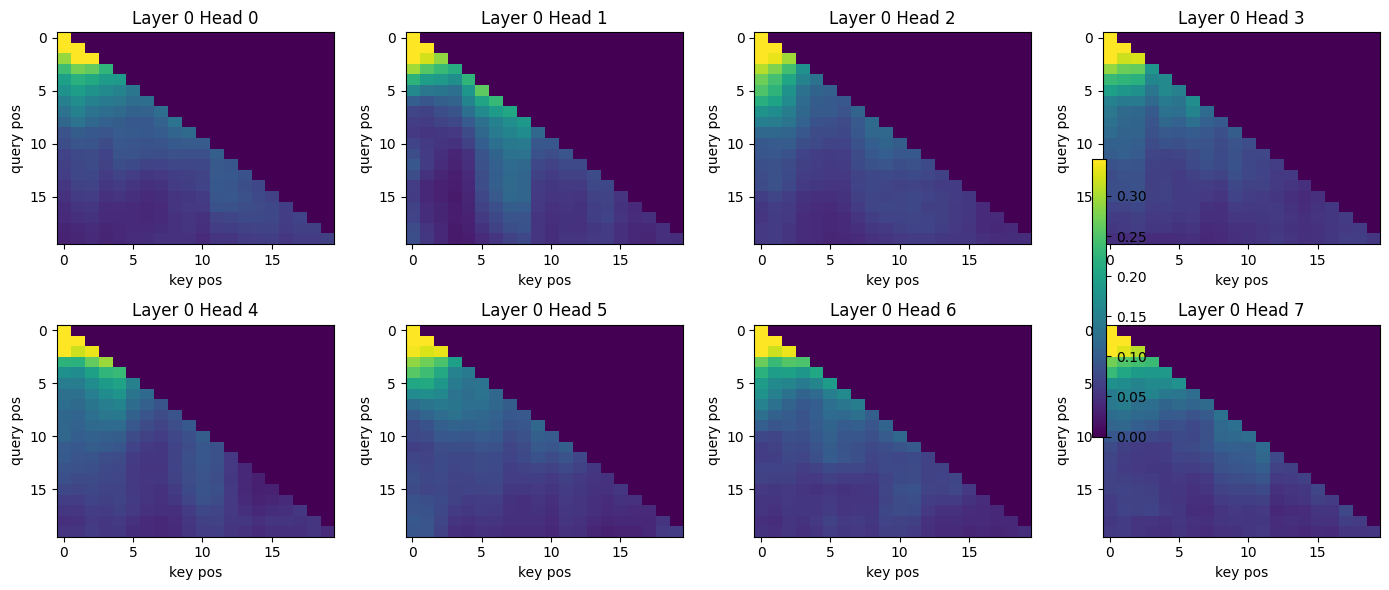


=== Layer 1 per-head heatmaps ===


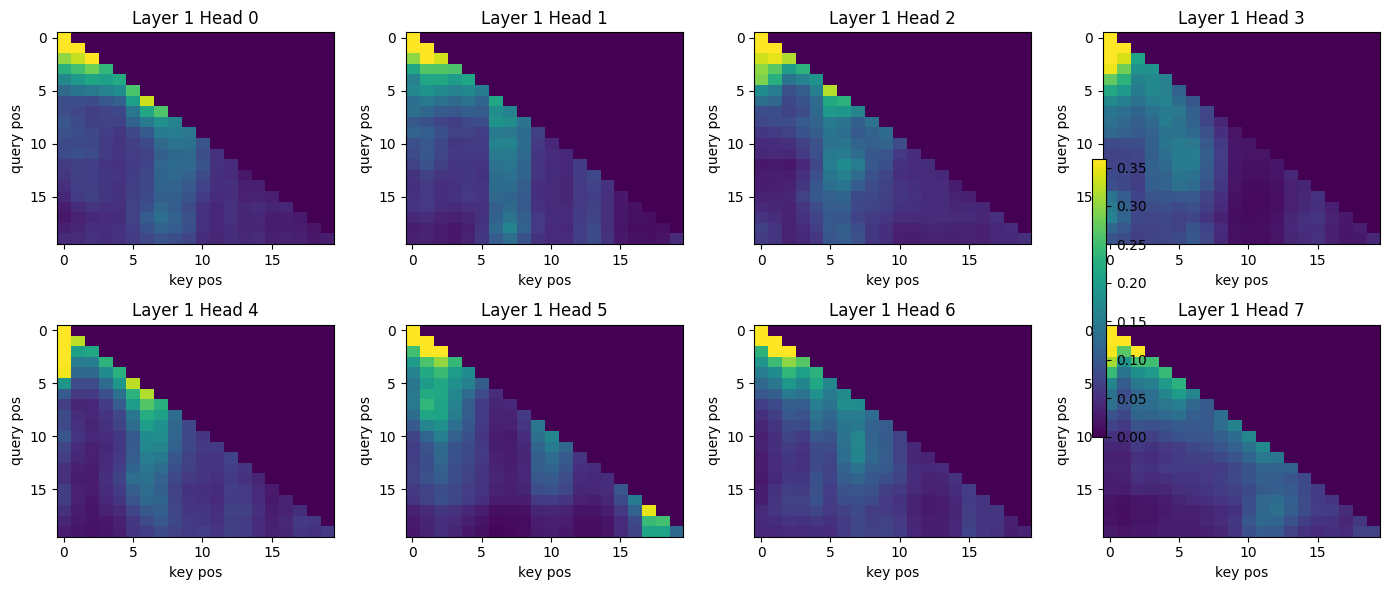

In [27]:
num_to_plot = min(2, len(attn_all))
for layer_idx in range(num_to_plot):
    print(f"\n=== Layer {layer_idx} per-head heatmaps ===")
    att_layer = attn_all[layer_idx]
    vmax = np.percentile(att_layer, 99)
    plot_layer_heads(att_layer, layer_idx, vmax=vmax)


In [28]:
for s in stats:
    means = s['mean']
    stds = s['std']
    print(f"Layer {s['layer']}:")
    for h, (m, sd) in enumerate(zip(means, stds)):
        print(f"  Head {h}: mean={m:.6f}, std={sd:.6f}")


Layer 0:
  Head 0: mean=0.050000, std=0.081285
  Head 1: mean=0.050000, std=0.083625
  Head 2: mean=0.050000, std=0.082173
  Head 3: mean=0.050000, std=0.081087
  Head 4: mean=0.050000, std=0.081486
  Head 5: mean=0.050000, std=0.081350
  Head 6: mean=0.050000, std=0.081082
  Head 7: mean=0.050000, std=0.081099
Layer 1:
  Head 0: mean=0.050000, std=0.084275
  Head 1: mean=0.050000, std=0.084030
  Head 2: mean=0.050000, std=0.084354
  Head 3: mean=0.050000, std=0.086869
  Head 4: mean=0.050000, std=0.088633
  Head 5: mean=0.050000, std=0.088281
  Head 6: mean=0.050000, std=0.083237
  Head 7: mean=0.050000, std=0.083491
Layer 2:
  Head 0: mean=0.050000, std=0.083562
  Head 1: mean=0.050000, std=0.082094
  Head 2: mean=0.050000, std=0.081436
  Head 3: mean=0.050000, std=0.081241
  Head 4: mean=0.050000, std=0.081989
  Head 5: mean=0.050000, std=0.082421
  Head 6: mean=0.050000, std=0.081564
  Head 7: mean=0.050000, std=0.083263
Layer 3:
  Head 0: mean=0.050000, std=0.082674
  Head 1: mean

# Tes Attention Mass
Hasilnya menunjukkan tidak ada kebocoran, yang berarti implementasi masking yang dilakukan sudah benar

In [29]:
violations = validate_masking(attn_all, seq_len)
if len(violations)==0:
    print('Masking validation passed: no attention mass on future tokens (within tolerance).')
else:
    print('Masking violations found (layer, query_pos, future_mass):')
    for v in violations:
        print(v)

Masking validation passed: no attention mass on future tokens (within tolerance).


# Visualisasi Attention Weights
Token pada query_pos=5 hanya memberikan bobot atensi pada token di posisi 5 dan sebelumnya. Untuk semua posisi setelah 5 (yaitu 6, 7, 8, ...), bobot atensinya adalah nol. Ini menunjukkan secara visual bahwa model benar-benar tidak "mengintip" atau memperhatikan token-token di masa depan, sesuai dengan aturan masked self-attention.

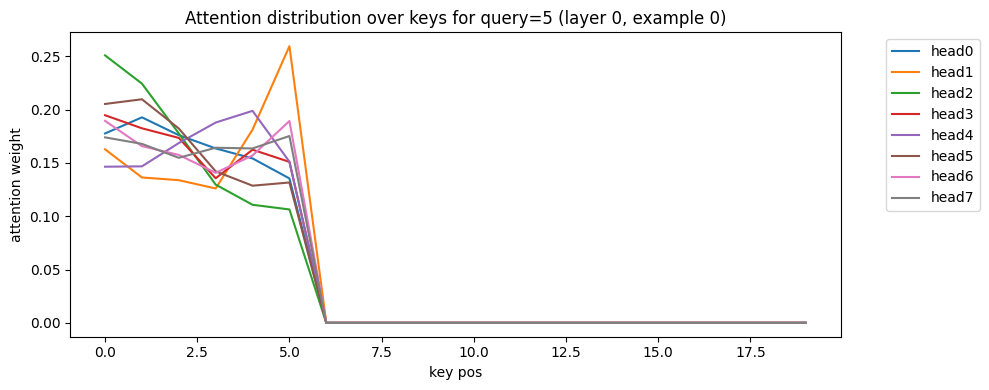

In [30]:
example = 0
query_pos = 5
layer_idx = 0
att = attn_all[layer_idx][example]

plt.figure(figsize=(10,4))
for h in range(att.shape[0]):
    plt.plot(att[h, query_pos], label=f'head{h}')
plt.title(f'Attention distribution over keys for query={query_pos} (layer {layer_idx}, example {example})')
plt.xlabel('key pos')
plt.ylabel('attention weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()